In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Let's define a function f

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

We can also plot it for a range of values

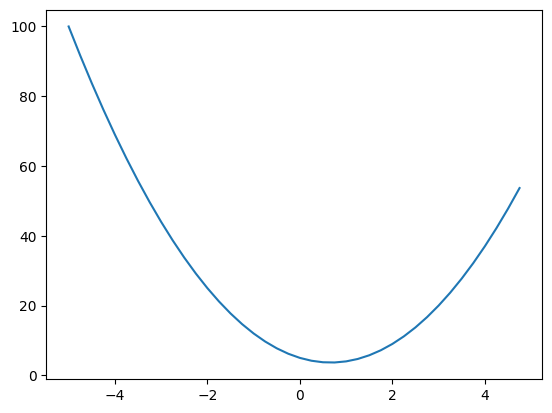

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

Now, what's a derivate?
> It is sensitivity of the function to the change of the output with respect to the input.

In simpler terms, (f(x+h) - f(x))/h, where h tends to zero. This gives us the slope.

In [5]:
h = 0.00001
x = 2/3
(f(x+h) - f(x))/h

3.0000002482211127e-05

Let's define a function with mupltiple inputs

In [6]:
a = 2.0
b = -3.0
c = 10.0

d = a*b + c
print(d)

4.0


In [7]:
h = 0.0001
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h) # By the good old derivation (wrt to a), we know that this will be b

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [8]:
h = 0.0001
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
b += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h) # By the good old derivation (wrt to b), we know that this will be a

d1 4.0
d2 4.0002
slope 2.0000000000042206


In [9]:
h = 0.0001
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h) # By the good old derivation (wrt to c), we know that this will be 1

d1 4.0
d2 4.0001
slope 0.9999999999976694


The NN will be mathematically very large expressions. We now start by building the data structures for this. Let's start by making the `Value` object from mircograd

In [131]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''): # Define a empty tuple `children` to keep the pointers of other Value objects
                                                             # Define a empty set `op` to keep track of what created that Value object
        self.data = data
        self.grad = 0.0 # this is the derivative of Value wrt to its nodes; initalized as 0 (we assume at the beginning that every Value doesn't impact the output)
        self._backward = lambda: None # for a leaf node, this should be nothing.
        self._prev = set(_children) # This will be a empty set when we define a new Value object (a, b, c)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other): # a.__add__(b)
        out = Value(self.data + other.data, (self, other), '+') # Since self.data and other.data is python floating point number,
                                                                # the addition is according to whatever is defined in the python kernel
        def _backward():
            self.grad +=  1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def __mul__(self, other): # a.__mul__(b) # You can't name it mult or multi, because we are defining magic methods for the Value object
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out

    def backward(self):
        
        topo = []
        visited = set()
        def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._prev:
              build_topo(child)
            topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        
        for node in reversed(topo):
            node._backward()

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd' #(a.__mul__(b)).__add__(c); you can also call this manually.
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
d

Value(data=4.0)

In [11]:
d._prev # This will gives us the Value objects that made d (the children of d, ik sounds wrong but it is what it is)

{Value(data=-6.0), Value(data=10.0)}

In [12]:
c._prev # Has no children

set()

In [13]:
d._op

'+'

In [27]:
# imported from mircograd's codebase

from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

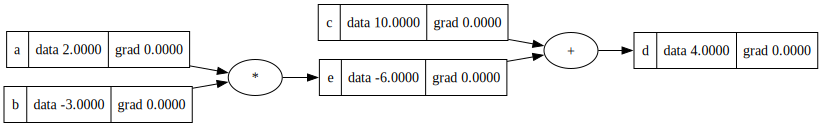

In [29]:
draw_dot(d)

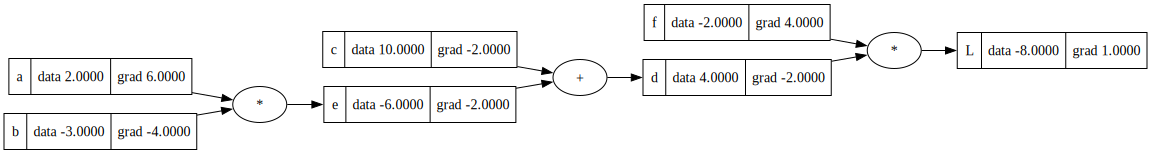

In [55]:
draw_dot(L)

The value of the forward pass is 8. We would now like to run backpropagation. We will start at the end and reverse and calculate the gradient along all these intermediate values. For every single value here, we are going to calculate the derivative of value (L) wrt every node. 

In a NN, we will be very interested in this derivative of the loss function wrt the weights of the NN. There will be data and weights, but the data is fixed, so our focus will be the only the derivatives wrt the weights.

In [58]:
def local_staging(): # just for our local testing
    h = 0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data
    
    a = Value(2.0 + h, label='a') # changing a by h
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print('a.grad',(L2 - L1)/h)

    a = Value(2.0, label='a') 
    b = Value(-3.0 + h, label='b') # changing b by h
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print('b.grad',(L2 - L1)/h) 

    a = Value(2.0, label='a') 
    b = Value(-3.0, label='b')
    c = Value(10.0 + h, label='c') # changing c by h
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print('c.grad',(L2 - L1)/h) 

    a = Value(2.0, label='a') 
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    e.data += h # changing e by h
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data

    print('e.grad',(L2 - L1)/h) 
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0 + h, label='f') # changing f by h
    L = d * f; L.label = 'L'
    L2 = L.data

    print('f.grad',(L2 - L1)/h)  # should be d

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    d.data += h  # changing d by h
    f = Value(-2.0, label='f') 
    L = d * f; L.label = 'L'
    L2 = L.data 

    print('d.grad',(L2 - L1)/h) # should be f

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data + h # changing L by h

    print('L.grad',(L2 - L1)/h)  # should be 1

local_staging()

a.grad 6.000000000000227
b.grad -3.9999999999995595
c.grad -1.9999999999988916
e.grad -2.000000000000668
f.grad 3.9999999999995595
d.grad -2.000000000000668
L.grad 1.000000000000334


In [34]:
L.grad = 1.0

L = d * f

dL/dd = ?
By calculus, we know that this will be f

In [38]:
f.grad = 4.0
d.grad = -2.0

to find dL/dc, let's start with dd/dc 

d = c + e;
so, dd/dc = 1 (and dd/de = 1)

This is a local derivative to study how c & e affects d. But we have to do this for L, and in a NN, there will be 1000s of such local derivatives.

So, let's use chain rule

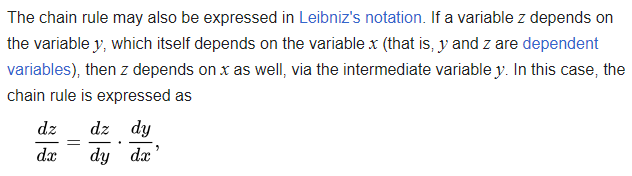

> Intuitively, the chain rule states that knowing the instantaneous rate of change of z relative to y and that of y relative to x allows one to calculate the instantaneous rate of change of z relative to x as the product of the two rates of change.

so,

dL/dc = dL/dd * dd/dc = -2.0 * 1 = -2.0

In [45]:
c.grad = -2.0
e.grad = -2.0

Now, to find dL/da and dL/db,

dL/da = (dL/dd * dd/de) * de/da = (dL/de) * de/da

dL/db = (dL/dd * dd/de) * de/db = (dL/de) * de/db

de/da = d(a*b)/da = b

de/db = d(a*b)/db = a

dL/da = -2.0 * -3.0 = 6.0

dL/db = -2.0 * 2.0 = -4.0

In [50]:
a.grad = 6.0
b.grad = -4.0

This was manual backpropagation! Let's nudge our inputs towards their gradients to increase L (single, manual optimization step) 

In [62]:
a.data += 0.001 * a.grad # 0.001 is the step size
b.data += 0.001 * b.grad
c.data += 0.001 * c.grad
f.data += 0.001 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-7.713030143999999


Let's look at another backpropagation using a neuron

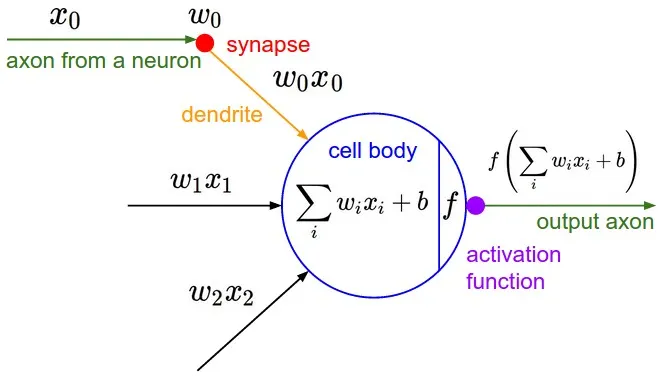

activation function is usually sigmoid or tanh [[more here]](https://en.wikipedia.org/wiki/Activation_function)

In [123]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'output'

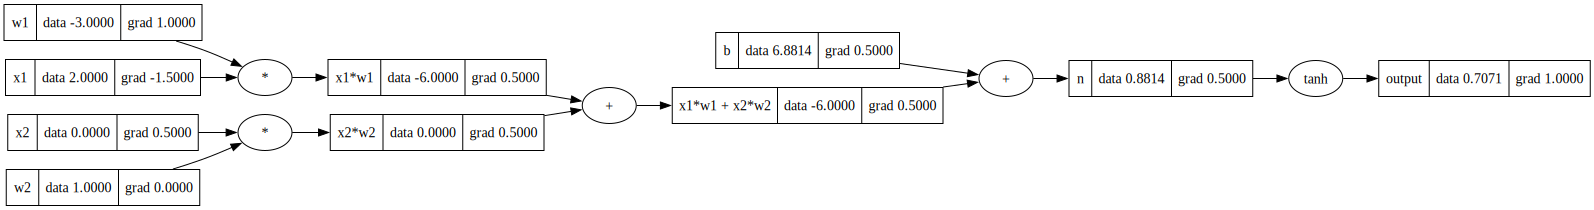

In [126]:
draw_dot(o)

In [73]:
o.grad = 1.0

In [80]:
# o = tanh(n)
# do/dn = 1 - tanh(n)**2 = 1 - o**2
print(1 - o.data**2)
n.grad = 0.5

0.4999999999999999


In [78]:
# a plus is just a distributor of gradient, so n.grad will flow to b and x1*w1 + x2*w2, and x1w1x2w2 will flow to x1w1 & x2w2
x1w1x2w2.grad = 0.5
b.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5

In [82]:
# a multi is front grad * the other child
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

Doing this manually is ridiculous. Let's implement this backprop in our Value object.

In [101]:
o.grad = 1.0 # we need to set the base case for o

In [102]:
o._backward()

In [108]:
n._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

Now, we get rid of us doing _backward manually. For this, we use topological sort [[more here](https://en.wikipedia.org/wiki/Topological_sorting)]

In [110]:
# imported from mircograd's codebase

topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

[Value(data=6.881373587019543),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [120]:
o.grad = 1.0

topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)

for node in reversed(topo):
    node._backward()

Now let's put this inside our Value object

In [125]:
o.backward()

We have a bug

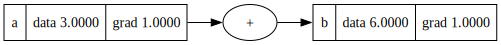

In [127]:
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

The grad of a should be 2, NOT 1!

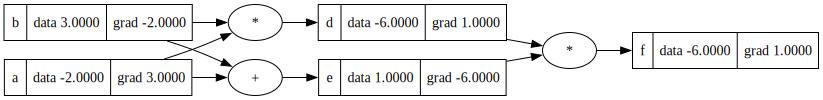

In [129]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

For a and b, there should be two leaves with grad -6.0 from e, and two leaves with grad 3.0 and -2.0. But the backprop only shows grad for one of the operations.

If you see the chain rule, for multivariate solutions, the gradients add up. Fixing this in our Value object.

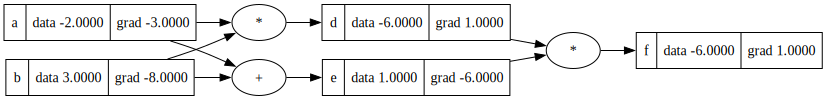

In [133]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward() # Fixed

draw_dot(f)